# Imgcluster
### Image clustering using the similarity algorithms: SIFT, SSIM, CW-SSIM, MSE

This project aims to implement the clustering of images by utilizing *Spectral Clustering* and *Affinity Propagation Clustering* together with a number of similarity algorithms, like: 

 * SIFT: Scale-invariant Feature Transform
 * SSIM: Structural Similarity Index
 * CW-SSIM: Complex Wavelet Structural Similarity Index
 * MSE: Mean Squared Error

The best clustering results are selected according to the calculated performance metrics for clustering:

 * Silhouette Coefficient
 * Completeness Score
 * Homogeneity Score

The project is using *OpenCV 3.1*, *Scikit-Learn*, *Scikit-Image* and *PySSIM* for image manipulations, similarity measurements and clustering.

All images have been downloaded from the free-of-charge online service [Pixabay](https://pixabay.com)

Any kind of copyrights, ownership rights or distribution rights have been considered according to the information, which is available on Pixabay.

This IP[y] Notebook performs a step-by-step execution of *'imgcluster_demo.py'* file with extra comments. The source code is available on [GitHub](https://github.com/llvll/imgcluster)

Let's start by exploring the main functions in *'imgcluster.py'* and *'get_image_similarity'* specifically.

In [2]:
import os
import datetime
import cv2
import numpy as np
import ssim.ssimlib as pyssim
from skimage.measure import structural_similarity as ssim
from sklearn.cluster import SpectralClustering, AffinityPropagation
from sklearn import metrics

# Constant definitions
SIM_IMAGE_SIZE = (640, 480)
SIFT_RATIO = 0.7
MSE_NUMERATOR = 1000.0
IMAGES_PER_CLUSTER = 5

""" Returns the normalized similarity value (from 0.0 to 1.0) for the provided pair of images.
    The following algorithms are supported:
    * SIFT: Scale-invariant Feature Transform
    * SSIM: Structural Similarity Index
    * CW-SSIM: Complex Wavelet Structural Similarity Index
    * MSE: Mean Squared Error
"""
def get_image_similarity(img1, img2, algorithm='SIFT'):
    # Converting to grayscale and resizing
    i1 = cv2.resize(cv2.imread(img1, cv2.IMREAD_GRAYSCALE), SIM_IMAGE_SIZE)
    i2 = cv2.resize(cv2.imread(img2, cv2.IMREAD_GRAYSCALE), SIM_IMAGE_SIZE)

    similarity = 0.0

    if algorithm == 'SIFT':
        # Using OpenCV for feature detection and matching
        sift = cv2.xfeatures2d.SIFT_create()
        k1, d1 = sift.detectAndCompute(i1, None)
        k2, d2 = sift.detectAndCompute(i2, None)

        bf = cv2.BFMatcher()
        matches = bf.knnMatch(d1, d2, k=2)

        for m, n in matches:
            if m.distance < SIFT_RATIO * n.distance:
                similarity += 1.0

        # Custom normalization for better variance in the similarity matrix
        if similarity == len(matches):
            similarity = 1.0
        elif similarity > 1.0:
            similarity = 1.0 - 1.0/similarity
        elif similarity == 1.0:
            similarity = 0.1
        else:
            similarity = 0.0
    elif algorithm == 'CW-SSIM':
        # FOR EXPERIMENTS ONLY!
        # Very slow algorithm - up to 50x times slower than SIFT or SSIM.
        # Optimization using CUDA or Cython code should be explored in the future.
        similarity = pyssim.SSIM(img1).cw_ssim_value(img2)
    elif algorithm == 'SSIM':
        # Default SSIM implementation of Scikit-Image
        similarity = ssim(i1, i2)
    else:
        # Using MSE algorithm with custom normalization
        err = np.sum((i1.astype("float") - i2.astype("float")) ** 2)
        err /= float(i1.shape[0] * i2.shape[1])

        if err > 0.0:
            similarity = MSE_NUMERATOR / err
        else:
            similarity = 1.0

    return similarity

According to the conducted experiments SIFT and SSIM provide the best balance of accuracy and performance for similarity measurements. CW-SSIM is more accurate in theory than SSIM, but its current performance is the major bottleneck for practical usages. The same process for similarity matrix with 20 images using CW-SSIM might run up to several hours! There is a clear need to explore CUDA or Cython for accelerating its performance. 

The similarity measurements are used for building the similarity matrix. Calculations are performed for the upper triangle only with the rest of cells to be filled by the transposed matrix. 

In [3]:
# Fetches all images from the provided directory and calculates the similarity
# value per image pair.
def build_similarity_matrix(dir_name, algorithm='SIFT'):
    images = os.listdir(dir_name)
    num_images = len(images)
    sm = np.zeros(shape=(num_images, num_images), dtype=np.float64)
    np.fill_diagonal(sm, 1.0)

    print("Building the similarity matrix using %s algorithm for %d images" %
          (algorithm, num_images))
    start_total = datetime.datetime.now()

    # Traversing the upper triangle only - transposed matrix will be used
    # later for filling the empty cells.
    k = 0
    for i in range(sm.shape[0]):
        for j in range(sm.shape[1]):
            j = j + k
            if i != j and j < sm.shape[1]:
                sm[i][j] = get_image_similarity('%s/%s' % (dir_name, images[i]),
                                                '%s/%s' % (dir_name, images[j]),
                                                algorithm=algorithm)
        k += 1

    # Adding the transposed matrix and subtracting the diagonal to obtain
    # the symmetric similarity matrix
    sm = sm + sm.T - np.diag(sm.diagonal())

    end_total = datetime.datetime.now()
    print("Done - total calculation time: %d seconds" % (end_total - start_total).total_seconds())
    return sm

There is a need to measure the performance of clustering itself. In *'imgcluster.py'* this is used for selecting the best clustering results between Spectral Clustering and Affinity Propagation. 

In [4]:
""" Returns a dictionary with the computed performance metrics of the provided cluster.
    Several functions from sklearn.metrics are used to calculate the following:
    * Silhouette Coefficient
      Values near 1.0 indicate that the sample is far away from the neighboring clusters.
      A value of 0.0 indicates that the sample is on or very close to the decision boundary
      between two neighboring clusters and negative values indicate that those samples might
      have been assigned to the wrong cluster.
    * Completeness Score
      A clustering result satisfies completeness if all the data points that are members of a
      given class are elements of the same cluster. Score between 0.0 and 1.0. 1.0 stands for
      perfectly complete labeling.
    * Homogeneity Score
      A clustering result satisfies homogeneity if all of its clusters contain only data points,
      which are members of a single class. 1.0 stands for perfectly homogeneous labeling.
"""
def get_cluster_metrics(X, labels, labels_true=None):
    metrics_dict = dict()
    metrics_dict['Silhouette coefficient'] = metrics.silhouette_score(X,
                                                                      labels,
                                                                      metric='precomputed')
    if labels_true:
        metrics_dict['Completeness score'] = metrics.completeness_score(labels_true, labels)
        metrics_dict['Homogeneity score'] = metrics.homogeneity_score(labels_true, labels)

    return metrics_dict

The main function to be invoked by applications is *'do_cluster'*. It accepts the path to directory with images for clustering. After executing Spectral Clustering and Affinity Propagation sequentially it compares the calculated peformance metrics and selects the best results. 

In [5]:
""" Executes two algorithms for similarity-based clustering:
    * Spectral Clustering
    * Affinity Propagation
    ... and selects the best results according to the clustering performance metrics.
"""
def do_cluster(dir_name, algorithm='SIFT', print_metrics=True, labels_true=None):
    matrix = build_similarity_matrix(dir_name, algorithm=algorithm)

    sc = SpectralClustering(n_clusters=int(matrix.shape[0]/IMAGES_PER_CLUSTER),
                            affinity='precomputed').fit(matrix)
    sc_metrics = get_cluster_metrics(matrix, sc.labels_, labels_true)

    if print_metrics:
        print("\nPerformance metrics for Spectral Clustering")
        print("Number of clusters: %d" % len(set(sc.labels_)))
        [print("%s: %.2f" % (k, sc_metrics[k])) for k in list(sc_metrics.keys())]

    af = AffinityPropagation(affinity='precomputed').fit(matrix)
    af_metrics = get_cluster_metrics(matrix, af.labels_, labels_true)

    if print_metrics:
        print("\nPerformance metrics for Affinity Propagation Clustering")
        print("Number of clusters: %d" % len(set(af.labels_)))
        [print("%s: %.2f" % (k, af_metrics[k])) for k in list(af_metrics.keys())]

    if (sc_metrics['Silhouette coefficient'] >= af_metrics['Silhouette coefficient']) and \
            (sc_metrics['Completeness score'] >= af_metrics['Completeness score'] or
             sc_metrics['Homogeneity score'] >= af_metrics['Homogeneity score']):
        print("\nSelected Spectral Clustering for the labeling results")
        return sc.labels_
    else:
        print("\nSelected Affinity Propagation for the labeling results")
        return af.labels_

Now let's try to run the demo itself ...

*DIR_NAME* value and the code in *'imgcluster_demo.py'* are updated for execution in IP[y] Notebook. *%matplotlib inline* is added for the correct rendering of images. Let's also increase the output window of IP[y] Notebook to fit all images without scrolling.

In [10]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

Building the similarity matrix using SIFT algorithm for 20 images
Done - total calculation time: 92 seconds

Performance metrics for Spectral Clustering
Number of clusters: 4
Homogeneity score: 0.21
Silhouette coefficient: -0.51
Completeness score: 0.22

Performance metrics for Affinity Propagation Clustering
Number of clusters: 3
Homogeneity score: 0.20
Silhouette coefficient: -0.02
Completeness score: 0.26

Selected Affinity Propagation for the labeling results

 --- Images from cluster #0 ---
Image field-of-poppies.jpg


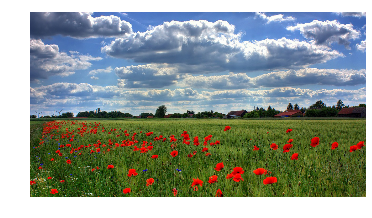

Image fox.jpg


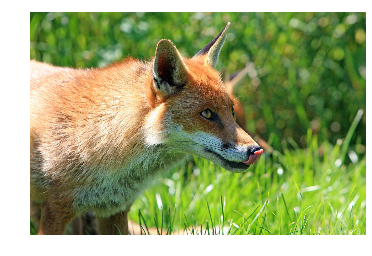

Image iphone.jpg


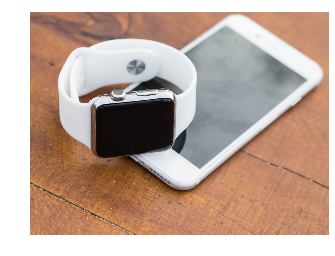

Image macbook.jpg


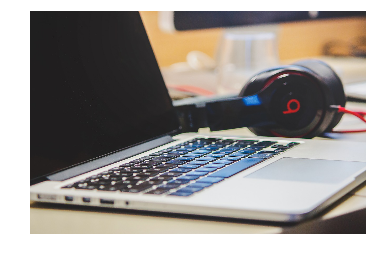

Image mobile.jpg


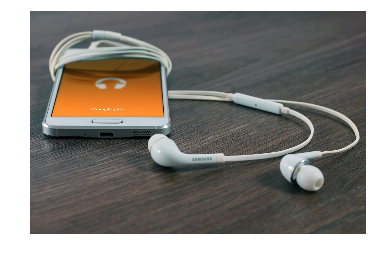

Image poppies.jpg


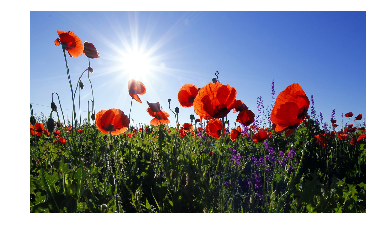

Image sea.jpg


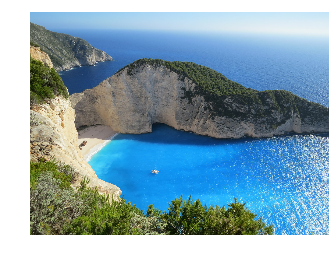

Image wanderer.jpg


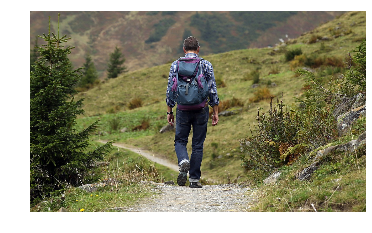


 --- Images from cluster #1 ---
Image bear.jpg


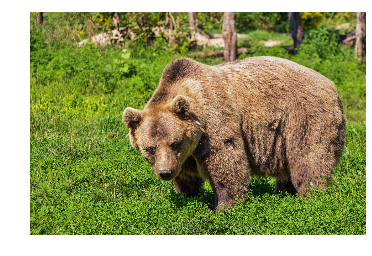

Image bike.jpg


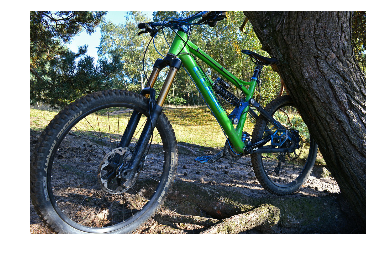

Image ferry-boat.jpg


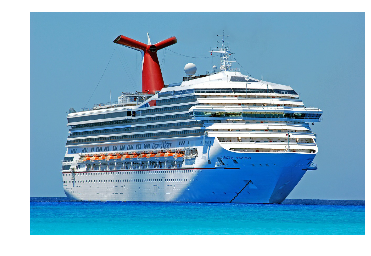

Image freerider.jpg


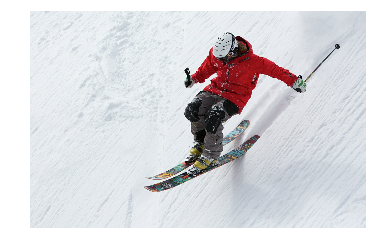

Image wolf.jpg


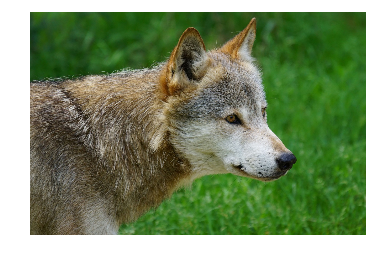


 --- Images from cluster #2 ---
Image imac.jpg


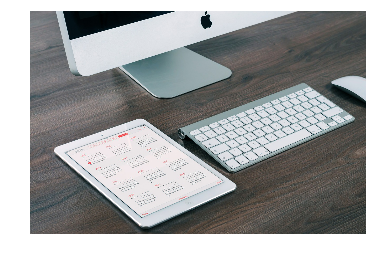

Image office.jpg


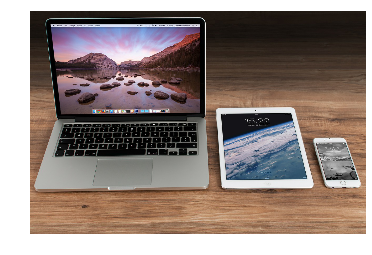

Image raccoon.jpg


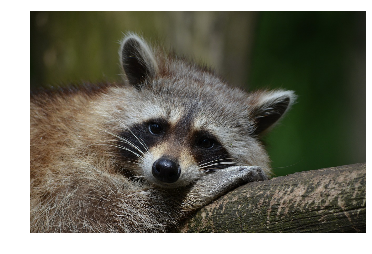

Image sailing-ship.jpg


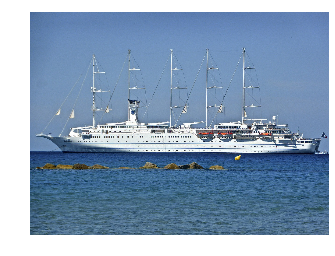

Image winter.jpg


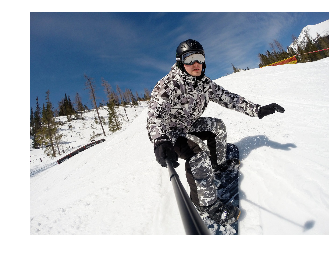

Image yacht-copy.jpg


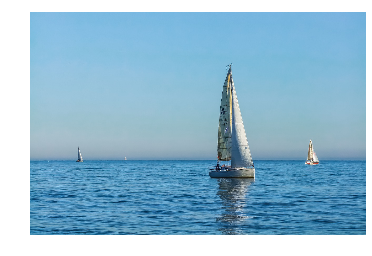

Image yacht.jpg


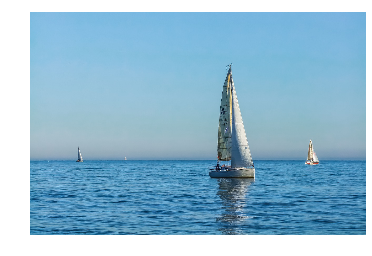

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt

DIR_NAME = '../images'

# Demo for clustering a set of 20 images using 'imgcluster' module.
# To be executed in the standalone mode by default. IP[y] Notebook requires some minor adjustments.

""" True (reference) labels for the provided images - defined manually according to the semantic
    meaning of images. For example: bear, raccoon and fox should belong to the same cluster.
    Please feel free to change the true labels according to your perception of these images  :-)
"""
TRUE_LABELS = [0, 1, 2, 1, 0, 1, 3, 3, 3, 3, 3, 1, 0, 2, 2, 1, 2, 0, 2, 2]

c = do_cluster(DIR_NAME, algorithm='SIFT', print_metrics=True, labels_true=TRUE_LABELS)
num_clusters = len(set(c))
images = os.listdir(DIR_NAME)
plt.axis('off')

for n in range(num_clusters):
    print("\n --- Images from cluster #%d ---" % n)

    for i in np.argwhere(c == n):
        if i != -1:
            print("Image %s" % images[i])
            img = cv2.imread('%s/%s' % (DIR_NAME, images[i]))
            plt.axis('off')
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.show()